# Bank Marketing

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
RANDOM_STATE = 3

In [5]:
df = pd.read_csv('/Users/gargd/Downloads/bank-full.csv', sep=',')

print(df.shape)
df.head(2)

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


All features are not normally distributed:

In [7]:
def describe(df):
    return pd.concat([df.describe().T,
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                     ], axis=1).T

describe(df.select_dtypes(include=['int64']))

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000
skew,0.684818,8.360308,0.093079,3.144318,4.898650,2.615715,41.846454
kurt,0.319570,140.751547,-1.059897,18.153915,39.249651,6.935195,4506.860660


In [8]:
df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome,Target
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [9]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [10]:
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

In categorical signs there are omissions under the guise of `unknown'. Let's look at the percentage of their content in the data:

In [11]:
df_missings = df.copy().select_dtypes(include=['object'])
df_missings = df_missings.replace('unknown', np.nan)

df_missings.isna().mean() * 100

job           0.637013
marital       0.000000
education     4.107407
default       0.000000
housing       0.000000
loan          0.000000
contact      28.798301
month         0.000000
poutcome     81.747805
Target        0.000000
dtype: float64

We see that in the columns `poutcome` and `contact` 82% and 29% are missing, respectively.

### Preprocessing

I think it's worth deleting the rows that have the value `unknown`, because in our case the data is not balanced and the model may not predict the result correctly in the future.

In [12]:
df = df[
    (df.education != 'unknown') &
    (df.poutcome != 'unknown') &
    (df.job != 'unknown') &
    (df.contact != 'unknown')
]

df.shape

(7842, 17)

I encode all categorical features using the usual LabelEncoder. You can try others.

In [13]:
from sklearn.preprocessing import LabelEncoder

df_copy = df.copy()

label_encoder = LabelEncoder()
for col in df_copy.select_dtypes(["object", "category"]):
    df_copy[col] = label_encoder.fit_transform(df_copy[col])

### EDA

In [14]:
num_cols = [x for x in df.columns if df[x].dtype != 'object']
cat_cols = [x for x in df.columns if df[x].dtype == 'object']

The graph below shows that all the features do not have a linear relationship. Thanks to the “duration” attribute, you can notice that there is a fuzzy but boundary separating the target attribute when people answered “yes” or “no”. This is logical, because if a person listens to a deposit offer for a long time, then he is most likely interested in the offer. In other signs the connection is poorly visible. This graph also shows that all distributions are not normally distributed.

In [ ]:
sns.pairplot(df, hue='Target')

The graph below shows that some categorical features have a greater influence on the target feature than others. For example, people with the “management” profession more often say “yes” to the target attribute than people with the “blue-collar” profession. It is also clear that there is a significant imbalance in the target attribute.

In [ ]:
fig, ax= plt.subplots(nrows=5, ncols=2, figsize= (14,16))
sns.countplot(y='job', hue='Target', data=df, ax=ax[0][0])
sns.countplot(y='marital', hue='Target', data=df, ax=ax[0][1])
sns.countplot(y='education', hue='Target', data=df, ax=ax[1][0])
sns.countplot(y='default', hue='Target', data=df, ax=ax[1][1])
sns.countplot(y='housing', hue='Target', data=df, ax=ax[2][0])
sns.countplot(y='loan', hue='Target', data=df, ax=ax[2][1])
sns.countplot(y='contact', hue='Target', data=df, ax=ax[3][0])
sns.countplot(y='month', hue='Target', data=df, ax=ax[3][1])
sns.countplot(y='poutcome', hue='Target', data=df, ax=ax[4][0])
sns.countplot(y='Target', data=df, ax=ax[4][1]);

From the graph below you can see that 3 numerical characteristics are quite noticeably separated by the target characteristic (columns “duration”, “campaign” and “pdays”).

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(11,14))
sns.boxplot(x='Target', y='age', data=df, ax=ax[0][0])
sns.boxplot(x='Target', y='balance', data=df, ax=ax[0][1])
sns.boxplot(x='Target', y='day', data=df, ax=ax[1][0])
sns.boxplot(x='Target', y='duration', data=df, ax=ax[1][1])
sns.boxplot(x='Target', y='campaign', data=df, ax=ax[2][0])
sns.boxplot(x='Target', y='pdays', data=df, ax=ax[2][1])
sns.boxplot(x='Target', y='previous', data=df, ax=ax[3][0]);

Based on the graph below, you can see that “housing”, “duration”, “pdays” and “poutcome” interact quite strongly with the target attribute.

In [ ]:
corr = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1g')

### Feature Engineering

In [15]:
X = df_copy.drop(['Target', 'duration'], axis=1)
y = df_copy['Target']

Mutual Information

In [16]:
from sklearn.feature_selection import mutual_info_classif


def make_mi_scores(x, y):
    """ Вычислить показатель MI для каждого признака типа int. """

    x = x.copy()
    for colname in x.select_dtypes(["object", "category"]):
        x[colname], _ = x[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    
    mi_scores = mutual_info_classif(x, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

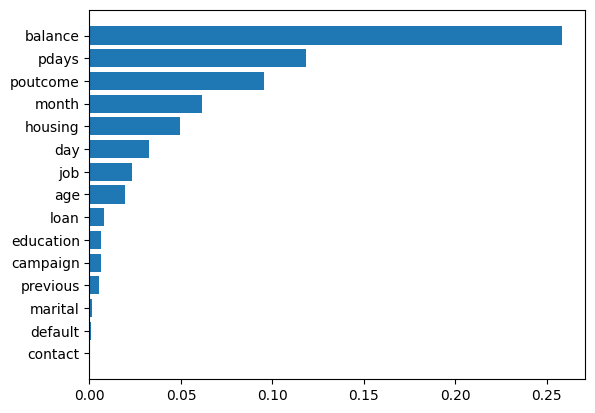

In [17]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

### Models
We will test several models:

In [18]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


def score_models(x, y, models: dict, scoring='precision'):

    scores = {}
    
    for name, model in models.items():
        score = score_dataset(x, y, model, scoring)
        scores[name] = score
    
    return scores
        
def score_dataset(x, y, model, scoring='precision'):

    for colname in x.select_dtypes(['category', 'object']):
        x[colname], _ = x[colname].factorize()

    score = cross_val_score(
        model, x, y, cv=5, scoring=scoring,
    )

    score = score.mean()
    return score

Baseline with all the features:

In [19]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE),
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoostClassifier': CatBoostClassifier(verbose=False, random_state=RANDOM_STATE),
}
score_models(X, y, models)

[LightGBM] [Info] Number of positive: 1429, number of negative: 4844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227802 -> initscore=-1.220766
[LightGBM] [Info] Start training from score -1.220766
[LightGBM] [Info] Number of positive: 1428, number of negative: 4845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 15
[LightGBM] [Info] [binary:

{'RandomForestClassifier': 0.24906690578404653,
 'XGBClassifier': 0.12805670565235577,
 'LGBMClassifier': 0.13828375365714685,
 'CatBoostClassifier': 0.12805006036800406}

Models with features by mutual information score (see above):

In [20]:
score_models(X[['balance', 'pdays', 'poutcome']], y, models)

[LightGBM] [Info] Number of positive: 1429, number of negative: 4844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227802 -> initscore=-1.220766
[LightGBM] [Info] Start training from score -1.220766
[LightGBM] [Info] Number of positive: 1428, number of negative: 4845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227642 -> initscore=-1.221672
[LightGBM] [Info] Start training from score -1.221672
[LightGBM] [Info] Numb

{'RandomForestClassifier': 0.48571768655042896,
 'XGBClassifier': 0.5490159964170044,
 'LGBMClassifier': 0.5990716208569549,
 'CatBoostClassifier': 0.611483247914965}

We can see that the basic CatBoostClassifier model is doing the best so far. Let's apply the permutation importance method for this model.We can see that the basic CatBoostClassifier model is doing the best so far. Let's apply the permutation importance method for this model:

In [21]:
score_models(X[['poutcome', 'pdays']], y, models)

[LightGBM] [Info] Number of positive: 1429, number of negative: 4844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227802 -> initscore=-1.220766
[LightGBM] [Info] Start training from score -1.220766
[LightGBM] [Info] Number of positive: 1428, number of negative: 4845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227642 -> initscore=-1.221672
[LightGBM] [Info] Start training from score -1.221672
[LightGBM] [Info] Numb

{'RandomForestClassifier': 0.47461335724054443,
 'XGBClassifier': 0.5925242580212007,
 'LGBMClassifier': 0.6152181640700157,
 'CatBoostClassifier': 0.6279093372226192}

CatBoostClassifier is still the best of all. Let's see what signs he considers important when predicting.CatBoostClassifier is still the best of all. Let's see what signs he considers important when predicting.

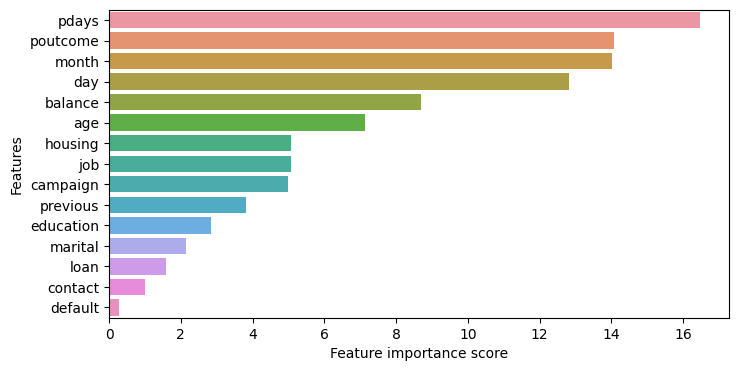

In [22]:
model = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE)
model.fit(X, y)

feature_scores = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
score_models(X[['pdays', 'month', 'poutcome', 'day']], y, models)

[LightGBM] [Info] Number of positive: 1429, number of negative: 4844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227802 -> initscore=-1.220766
[LightGBM] [Info] Start training from score -1.220766
[LightGBM] [Info] Number of positive: 1428, number of negative: 4845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 6273, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227642 -> initscore=-1.221672
[LightGBM] [Info] Start training from score -1.221672
[LightGBM] [Info] Numb

Hmmm... It looks strange, don't you agree?

Let's try to experiment on our own, based on the graph above.Let's try to experiment on our own, based on the graph above.

In [ ]:
score_models(X[['pdays']], y, models)

In [ ]:
score_models(X[['month']], y, models)

In [ ]:
score_models(X[['poutcome']], y, models)

Wow! If we train models on one feature of `poutcome`, then we get the best quality!

Let's try something else:

In [ ]:
score_models(X[['poutcome', 'month']], y, models)

In [ ]:
score_models(X[['poutcome', 'day']], y, models)

In [ ]:
score_models(X[['poutcome', 'balance']], y, models)

In [ ]:
score_models(X[['poutcome', 'age']], y, models)

Okay, it seems there won't be a combination of the best one sign of `poutcome' anymore.

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=200,test_size=0.2,stratify=y)
#Scaling the data for model efficiency
from sklearn.preprocessing import StandardScaler #Importing library
ss=StandardScaler() #Creating an object
ss.fit(xtrain) #Fitting train data
xtrain=ss.transform(xtrain) #Transforming train data
xtest=ss.transform(xtest) #Transforming test data


In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=200,test_size=0.2,stratify=y)

In [ ]:
print("Training data shapes:", xtrain.shape, ytrain.shape)
print("Testing data shapes:", xtest.shape, ytest.shape)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

    
def create_model(algo):
    model_mapping = {
        "XGBClassifier": XGBClassifier,
        "LGBMClassifier": LGBMClassifier,
        "CatBoostClassifier": CatBoostClassifier,
        "randomforest":RandomForestClassifier,
        "logistic":LogisticRegression,
        "svc":SVC
    }

    if algo in model_mapping:
        return model_mapping[algo]()
    else:
        raise ValueError(f"Unsupported algorithm: {algo}")

algo = ["XGBClassifier", "LGBMClassifier", "CatBoostClassifier","randomforest","logistic","svc"]
accuracy=[]
names=[]
accuracy_scores=[]
for i in algo:
    model_name = f"{i}model"
    names.append(model_name)
    model= create_model(i)
    model.fit(xtrain,ytrain)
    ypred=model.predict(xtest)
    accuracy.append(accuracy_score(ytest, ypred))
    accuracy_scores.append((model_name,accuracy_score(ytest, ypred)))      
    train_score=model.score(xtrain,ytrain)
    test_score=model.score(xtest,ytest)
    cm=confusion_matrix(ytest,ypred)
    cr=classification_report(ytest,ypred)
    ac=accuracy_score(ytest,ypred)
    roc_auc=roc_auc_score(ytest,ypred)
    fpr,tpr,threshold=roc_curve(ytest,ypred)
    plt.plot(fpr,tpr,label=model)
    print(f'Model:{model}\nTraining Score: {train_score}\nTesting Score: {test_score}\nConfusion Matrix: \n{cm}\
    \nClassification_report\n{cr}\nAccuracy Score: {ac}\nROC_AUC_Score: {roc_auc}\nFalsePositiveRate: {fpr}')
    print()

In [ ]:
for i in accuracy_scores:    
    print(f"Accuracy Score of {i}")

In [ ]:
df_accuracy = pd.DataFrame({'Model': [item for item in names], 'Accuracy Score': [item for item in accuracy]})
plt.figure(figsize=(8,8))
sns.scatterplot(x="Model", y="Accuracy Score", data=df_accuracy, hue='Model', palette='viridis')
plt.title('Scatter Plot of Accuracy Scores for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("accuracy_score.png")


### Сonfusion matrix 

On average, CatBoostClassifier showed better results than other models. Therefore, only this model will be used further.

In [ ]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(x, y, model):
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize = (4,4))
    b = sns.heatmap(cf_matrix, annot=True, fmt='g')
    b.set(title='Confusion Matrix')
    b.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

In [ ]:
create_confusion_matrix(X[['poutcome']], y, CatBoostClassifier(verbose=False, random_state=RANDOM_STATE))

### Fine-tuning CatBoostClassifier with Optuna

Fitting a model for a single `poutcome` attribute is pointless, because the result will be the same everywhere. I checked it behind the scenes, believe me :)

Let's try to select parameters for a complete dataset:

In [ ]:
import optuna


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 900, 1100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1100),
    }

    model = CatBoostClassifier(**params, verbose=False, random_state=RANDOM_STATE)

    return score_dataset(X, y, model)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Wow! I used optuna for the first time and got very good results compared to my previous experiments :) That's why it's recommended everywhere...

In [ ]:
score_dataset(
    X,
    y,
    CatBoostClassifier(**trial.params, verbose=False, random_state=RANDOM_STATE)
)

I wonder what signs this model with the hyperparameters found calls the most important?

In [ ]:
model = CatBoostClassifier(**trial.params, verbose=False, random_state=RANDOM_STATE)
model.fit(X, y)

feature_scores = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

Interesting! I didn't consider `housing` before, but it turned out to be important.

In [ ]:
create_confusion_matrix(
    X,
    y,
    CatBoostClassifier(**trial.params, verbose=False, random_state=RANDOM_STATE)
)

It seems I did the selection of functions in vain, it was possible to start with Optuna, and then make a fit-predict :)

## Conclusion
From the experiments carried out, CatBoostClassifier showed good results on the metric `precision` = 0.77

What can be improved?
- It is worth balancing the classes.
- To improve, you need to try the Feature Extraction methods. For example, from the signs `month` and `day`, you can try to identify the day of the week. True, we do not know the year, but definitely some day of the week can be an informative sign for predicting the target.
- Also, I did not normalize/standardize numerical features. Maybe it will improve the quality?
- Maybe there are better models besides CatBoost? If you know, be sure to write!

**Thank you for coming to the end :)**